In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [4]:
train = pd.read_csv('data/raw/train.csv')
test = pd.read_csv('data/raw/test.csv')

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
import lightgbm as lgb

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

A = Baseline  
B = SS  
C = CA  
D = DA

Count  occurance of each events

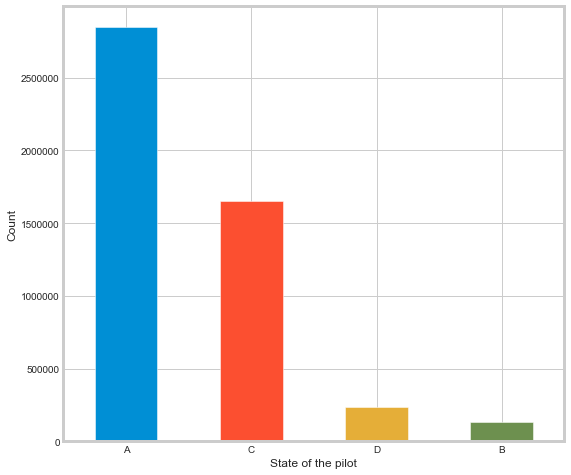

In [6]:
plt.figure(figsize=(8,8))
train['event'].value_counts().plot.bar()
plt.xlabel('State of the pilot')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [7]:
#print(train.head())
#train.groupby(by=(['experiment','event']), as_index=True)['event'].agg('count')
print(train.groupby(by=(['experiment','event']), as_index=True)[['event']].agg(['count']))
train.groupby(by=(['experiment','event']), as_index=False)[['event']].agg(['count'])

                    event
                    count
experiment event         
CA         A         5690
           C      1652686
DA         A      1423064
           D       235329
SS         A      1420055
           B       130597


event
                    count
experiment event         
CA         A         5690
           C      1652686
DA         A      1423064
           D       235329
SS         A      1420055
           B       130597

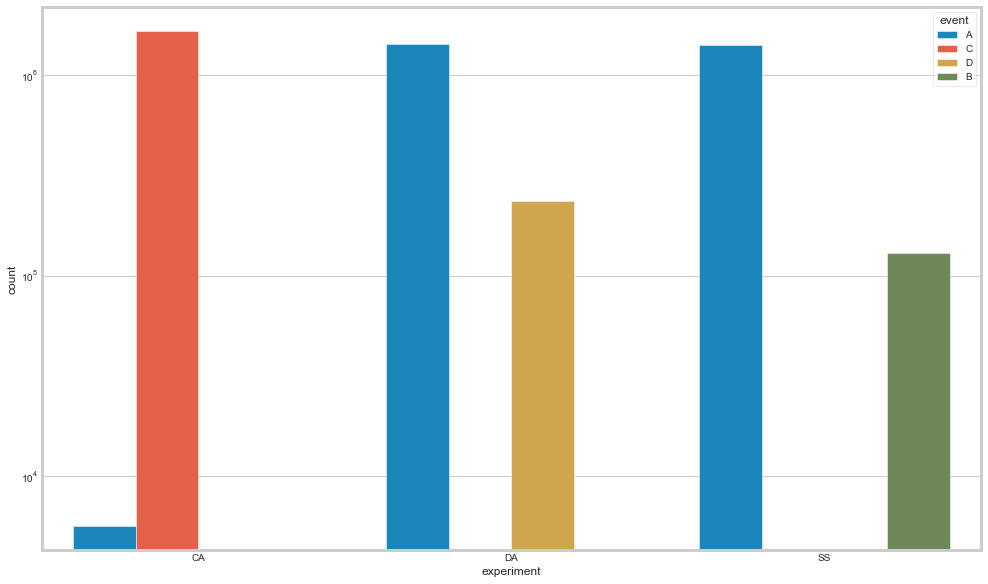

In [8]:
plt.figure(figsize=(15, 10))
sns.countplot('experiment', hue='event', data=train)
plt.yscale('log')
plt.show()

In [9]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", 
                "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", 
                "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", 
                "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

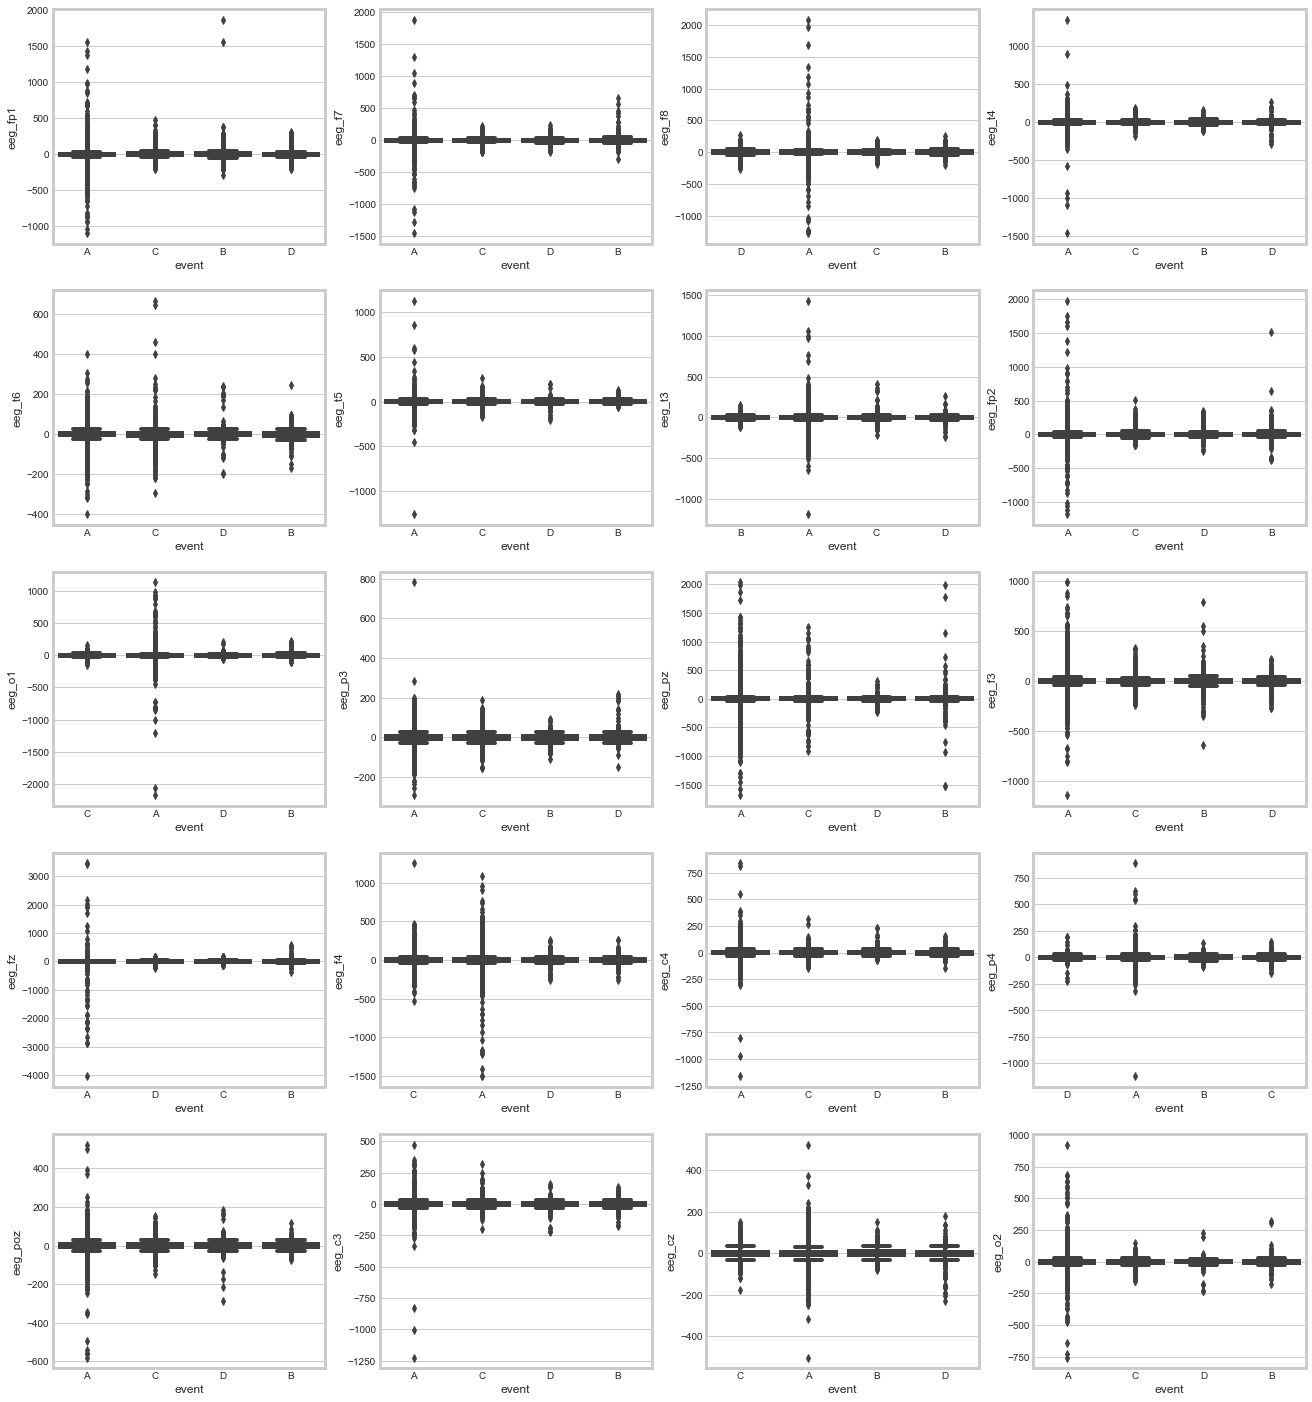

In [10]:
plt.figure(figsize=(20,25))
i = 0

for egg in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.boxplot(x='event', y=egg, data=train.sample(50000))
    
plt.show()

In [11]:
features_n = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", 
              "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", 
              "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", 
              "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2", 
              "ecg", "r", "gsr"]

In [12]:
train['pilot'] = 100 * train['seat'] + train['crew']
test['pilot'] = 100 * test['seat'] + test['crew']

In [13]:
print("Number of pilots: ", len(train['pilot'].unique()))

Number of pilots:  18


## **Train/Test Split**

In [14]:
train, val = train_test_split(train, test_size = 0.2, random_state=0)

In [15]:
print(f"Training on {train.shape[0]} samples")

Training on 3893936 samples


## **Model**

In [16]:
features = ['crew','seat'] + features_n

def run_lgb(train, test):
    dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    try:
        train['event'] = train['event'].apply(lambda x: dic[x])
        test['event'] = test['event'].apply(lambda x: dic[x])
    except:
        pass
    
    params = {'objective': 'multiclass',
             'num_class': 4, 
             'metric': 'multi_error',
             'min_child_weight': 50, 
             'learning_rate': 0.1, 
             'bagging_fraction': 0.7, 
             'feature_fraction': 0.7, 
             'bagging_speed': 420,
             'verbosity': -1}
    
    lg_train = lgb.Dataset(train[features], label=(train['event']))
    lg_test = lgb.Dataset(test[features], label=(test['event']))
    model = lgb.train(params, lg_train, 1000, valid_sets=[lg_test], early_stopping_rounds=50, 
                      verbose_eval=100)
    return model

In [17]:
import pickle

#file = open('../input/model','wb')
file = open('working/model','wb')
model = run_lgb(train, val)
s = pickle.dump(model, file)
file.close()

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_error: 0.0840968
[200]	valid_0's multi_error: 0.0684469
[300]	valid_0's multi_error: 0.0606245
[400]	valid_0's multi_error: 0.0558375
[500]	valid_0's multi_error: 0.0524405
[600]	valid_0's multi_error: 0.0496679
[700]	valid_0's multi_error: 0.0473515
[800]	valid_0's multi_error: 0.0454953
[900]	valid_0's multi_error: 0.0438497
[1000]	valid_0's multi_error: 0.0423746
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_error: 0.0423746
